# Caffe to Caffe2 Translator Tutorial

In this example we will convert a pre-existing Caffe model into a format that will be supported by Caffe2. This tutorial requires the following additional modules that you may not have installed yet:

- matpotlib
- skimage
- pyyaml (required by caffe/scripts/download_model_binary.py)

Use conda, pip, or `sudo apt-get install` to get these modules.

You will also need the original Caffe repo because this tutorial uses tools and resources from Caffe. You configure the Caffe location in the second code block below. This tutorial also assumes that you have existing .caffemodel models and supporting files to convert. If not, see the tutorial called [Getting Models and Datasets](Getting_Models_and_Datasets.ipynb).

In [1]:
%matplotlib inline
from caffe.proto import caffe_pb2
from caffe2.proto import caffe2_pb2
from cStringIO import StringIO
from google.protobuf import text_format
from IPython import display
import matplotlib.image as mpimg
from matplotlib import pyplot
import numpy as np
import os
from caffe2.python import caffe_translator, visualize, workspace, net_drawer
import skimage
import skimage.io
import skimage.transform
import sys
print("Required modules imported.")

Required modules imported.


Below you will set your file path in `CAFFE_ROOT` according to your current installation of Caffe.
You will also set the model that you're converting with `MODEL`. This will be matched with the filename of the model that you may already have downloaded, or else the script will go fetch the pre-trained model (ilsvrc_aux) for you from the BVLC repository using the script included. Note that the required resources here are:

* Pretrained binary: .caffemodel
* Model file: deploy.prototxt

At this point, the only two things you should play with below are:

- CAFFE_ROOT: where you have the Caffe repository
- MODEL: which model you're trying to convert

If you get any errors then look back at the top for the link to resources or tutorial for getting pre-trained models and datasets.

In [2]:
# This should point to the root folder of Caffe that you checked
# out from https://github.com/BVLC/caffe
# You can do it by
#     git clone https://github.com/BVLC/caffe.git
CAFFE_ROOT = os.path.expanduser('~/caffe')

# format below is the model's folder, model's dataset inside that folder
# you can switch the comments on MODEL to try out different model conversions
MODEL = 'bvlc_googlenet', 'bvlc_googlenet.caffemodel', 'this one is fast'
#MODEL = 'bvlc_alexnet', 'bvlc_alexnet.caffemodel', 'this one takes a minute' 

if not os.path.exists(CAFFE_ROOT):
    print("Houston, you may have a problem.") 
    print("Did you change CAFFE_ROOT to point to your local Caffe repo?")
    print("Try running: git clone https://github.com/BVLC/caffe.git")

CAFFE_MODELS = os.path.join(CAFFE_ROOT, 'models')
# this is like: ~/caffe/models/bvlc_alexnet/deploy.prototxt
CAFFE_MODEL_FILE = os.path.join(CAFFE_MODELS, MODEL[0], 'deploy.prototxt')
# this is like: ~/caffe/models/bvlc_alexnet/bvlc_alexnet.caffemodel
CAFFE_PRETRAINED = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[1])

if not os.path.exists(CAFFE_PRETRAINED):
    print(CAFFE_PRETRAINED + " not found!")
else:
    print("Found the .caffemodel! Now looking for deploy.prototxt...")
    if not os.path.exists(CAFFE_MODEL_FILE):
        print("Caffe model file, " + CAFFE_MODEL_FILE + " was not found!")
    else:
        print('All needed files found! Load the model in the next step.')

Found the .caffemodel! Now looking for deploy.prototxt...
All needed files found! Load the model in the next step.


In [3]:
caffenet = caffe_pb2.NetParameter()
caffenet_pretrained = caffe_pb2.NetParameter()
text_format.Merge(open(CAFFE_MODEL_FILE).read(), caffenet)
caffenet_pretrained.ParseFromString(open(CAFFE_PRETRAINED).read())
print('Model loaded.')    

# TODO: explain why this is needed
DATASET = 'imagenet.bet.pickle'
CAFFE_DATA = os.path.join(CAFFE_ROOT, 'data/ilsvrc12')
if not os.path.exists(os.path.join(CAFFE_DATA, DATASET)):
    print("Dataset wasn't found. Downloading...")
    os.system(os.path.join(CAFFE_DATA, 'get_ilsvrc_aux.sh'))

Model loaded.


In the next step the model will be translated to Caffe2 format.

In [4]:
# Perform translation, using the caffenet and pretrained parameters.
print('Translating model.')
net, pretrained_params = caffe_translator.TranslateModel(
    caffenet, caffenet_pretrained, is_test=True)
print('Model translated.')

INFO:caffe_translator:Translate layer data
INFO:caffe_translator:Translate layer conv1/7x7_s2
INFO:caffe_translator:Translate layer conv1/relu_7x7
INFO:caffe_translator:Translate layer pool1/3x3_s2
INFO:caffe_translator:Translate layer pool1/norm1
INFO:caffe_translator:Translate layer conv2/3x3_reduce
INFO:caffe_translator:Translate layer conv2/relu_3x3_reduce
INFO:caffe_translator:Translate layer conv2/3x3
INFO:caffe_translator:Translate layer conv2/relu_3x3
INFO:caffe_translator:Translate layer conv2/norm2
INFO:caffe_translator:Translate layer pool2/3x3_s2
INFO:caffe_translator:Translate layer inception_3a/1x1
INFO:caffe_translator:Translate layer inception_3a/relu_1x1


Translating model.


INFO:caffe_translator:Translate layer inception_3a/3x3_reduce
INFO:caffe_translator:Translate layer inception_3a/relu_3x3_reduce
INFO:caffe_translator:Translate layer inception_3a/3x3
INFO:caffe_translator:Translate layer inception_3a/relu_3x3
INFO:caffe_translator:Translate layer inception_3a/5x5_reduce
INFO:caffe_translator:Translate layer inception_3a/relu_5x5_reduce
INFO:caffe_translator:Translate layer inception_3a/5x5
INFO:caffe_translator:Translate layer inception_3a/relu_5x5
INFO:caffe_translator:Translate layer inception_3a/pool
INFO:caffe_translator:Translate layer inception_3a/pool_proj
INFO:caffe_translator:Translate layer inception_3a/relu_pool_proj
INFO:caffe_translator:Translate layer inception_3a/output
INFO:caffe_translator:Translate layer inception_3b/1x1
INFO:caffe_translator:Translate layer inception_3b/relu_1x1
INFO:caffe_translator:Translate layer inception_3b/3x3_reduce
INFO:caffe_translator:Translate layer inception_3b/relu_3x3_reduce
INFO:caffe_translator:Trans

Model translated.


For fun we can print out a graph of the operators. We can also change the code below to have it graph the blobs too.

GoogleNet


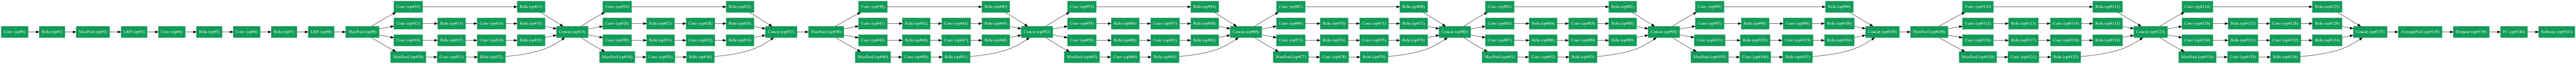

In [5]:
graph = net_drawer.GetPydotGraphMinimal(net.op, net.name, rankdir="LR")
print net.name
display.Image(graph.create_png(), width=800)
# The above command shows only the operators. If you want to see both the
# operators and the blobs, use the command below.
#graph = net_drawer.GetPydotGraph(net.operators, net.name, rankdir="BT")
#display.Image(graph.create_png(), width=500)

We can also list them by name:

In [6]:
for tensor in pretrained_params.protos:
    print tensor.name

conv1/7x7_s2_w
conv1/7x7_s2_b
conv2/3x3_reduce_w
conv2/3x3_reduce_b
conv2/3x3_w
conv2/3x3_b
inception_3a/1x1_w
inception_3a/1x1_b
inception_3a/3x3_reduce_w
inception_3a/3x3_reduce_b
inception_3a/3x3_w
inception_3a/3x3_b
inception_3a/5x5_reduce_w
inception_3a/5x5_reduce_b
inception_3a/5x5_w
inception_3a/5x5_b
inception_3a/pool_proj_w
inception_3a/pool_proj_b
inception_3b/1x1_w
inception_3b/1x1_b
inception_3b/3x3_reduce_w
inception_3b/3x3_reduce_b
inception_3b/3x3_w
inception_3b/3x3_b
inception_3b/5x5_reduce_w
inception_3b/5x5_reduce_b
inception_3b/5x5_w
inception_3b/5x5_b
inception_3b/pool_proj_w
inception_3b/pool_proj_b
inception_4a/1x1_w
inception_4a/1x1_b
inception_4a/3x3_reduce_w
inception_4a/3x3_reduce_b
inception_4a/3x3_w
inception_4a/3x3_b
inception_4a/5x5_reduce_w
inception_4a/5x5_reduce_b
inception_4a/5x5_w
inception_4a/5x5_b
inception_4a/pool_proj_w
inception_4a/pool_proj_b
inception_4b/1x1_w
inception_4b/1x1_b
inception_4b/3x3_reduce_w
inception_4b/3x3_reduce_b
inception_4b/3

For the next step of actually running the network, you have the option of CPU or GPU. It is setup for CPU by default, so if you want to use GPU you need to switch the comments below to enable the appropriate lines.

`pycaffe2.workspace` implements a very simple Model object that wraps the construction of the model. Specifically, what it will do is:
(1) feed the parameters to the workspace;
(2) Create input blob placeholders;
(3) Actually instantiating the Caffe network.

In [7]:
# We will first specify the device option: how we want to run the network.
#net.device_option.device_type = caffe2_pb2.CPU
# If you want to use cuda, use the following commands
net.device_option.device_type = caffe2_pb2.CUDA
net.device_option.cuda_gpu_id = 0

# Here we will simply use the Model object to host the model.
model = workspace.Model(net, pretrained_params, ["data"], ["prob"])
print 'Network created sucessfully.'

Feeding parameter conv1/7x7_s2_w
Feeding parameter conv1/7x7_s2_b
Feeding parameter conv2/3x3_reduce_w
Feeding parameter conv2/3x3_reduce_b
Feeding parameter conv2/3x3_w
Feeding parameter conv2/3x3_b
Feeding parameter inception_3a/1x1_w
Feeding parameter inception_3a/1x1_b
Feeding parameter inception_3a/3x3_reduce_w
Feeding parameter inception_3a/3x3_reduce_b
Feeding parameter inception_3a/3x3_w
Feeding parameter inception_3a/3x3_b
Feeding parameter inception_3a/5x5_reduce_w
Feeding parameter inception_3a/5x5_reduce_b
Feeding parameter inception_3a/5x5_w
Feeding parameter inception_3a/5x5_b
Feeding parameter inception_3a/pool_proj_w
Feeding parameter inception_3a/pool_proj_b
Feeding parameter inception_3b/1x1_w
Feeding parameter inception_3b/1x1_b
Feeding parameter inception_3b/3x3_reduce_w
Feeding parameter inception_3b/3x3_reduce_b
Feeding parameter inception_3b/3x3_w
Feeding parameter inception_3b/3x3_b
Feeding parameter inception_3b/5x5_reduce_w
Feeding parameter inception_3b/5x5_r

Here we're going to use the test kitty and show processing. It follows these steps:

1. Resize the image to 256\*256, and crop out the center.

2. Since Caffe expects CHW order and the current image is HWC, we will need to change the order.

3. Caffe uses a BGR order due to legacy OpenCV issues, so we will change RGB to BGR.

4. We will subtract the mean image. Note that skimage loads image in the [0, 1] range so we multiply the pixel values first to get them into [0, 255].

5. Finally, since caffe2 expects the input to have a batch term so we can feed in multiple images, we will simply prepend a batch dimension of size 1. Also, we will make sure image is of type np.float32.

Input shape is 224x224
Final input shape is: (1, 3, 224, 224)


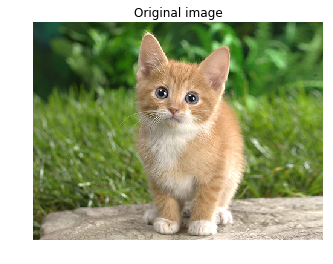

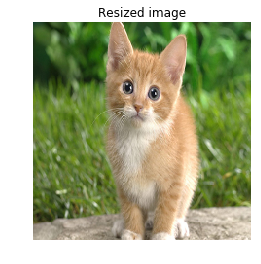

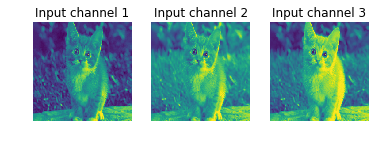

In [8]:
IMAGE_FILE = 'images/cat.jpg'
# TODO: second declaration of the cat, remove the first?
img = skimage.img_as_float(skimage.io.imread(IMAGE_FILE)).astype(np.float32)
pyplot.imshow(img)
pyplot.axis('off')
pyplot.title('Original image')
# Here are the steps we use to preprocess the image.
# (1) Resize the image to 256*256, and crop out the center.
input_height, input_width = 224, 224
print 'Input shape is %dx%d' % (input_height, input_width)
img = skimage.transform.resize(img, (256, 256))
crop_height = (256 - input_height) / 2
crop_width = (256 - input_width) / 2
img = img[crop_height:crop_height + input_height, 
          crop_width:crop_width + input_width]
pyplot.figure()
pyplot.imshow(img)
pyplot.axis('off')
pyplot.title('Resized image')
# (2) Since Caffe expects CHW order and the current image is HWC,
#     we will need to change the order.
img = img.swapaxes(1, 2).swapaxes(0, 1)
# (3) Caffe uses a BGR order due to legacy OpenCV issues, so we
#     will change RGB to BGR.
img = img[(2, 1, 0), :, :]
# (4) We will subtract the mean image. Note that skimage loads
#     image in the [0, 1] range so we multiply the pixel values
#     first to get them into [0, 255].
mean_file = os.path.join(CAFFE_ROOT, 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mean = np.load(mean_file).mean(1).mean(1)
img = img * 255 - mean[:, np.newaxis, np.newaxis]
pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(img[i])
    pyplot.axis('off')
    pyplot.title('Input channel %d' % (i+1))
# (5) finally, since caffe2 expect the input to have a batch term
#     so we can feed in multiple images, we will simply prepend a
#     batch dimension of size 1. Also, we will make sure image is
#     of type np.float32.
img = img[np.newaxis, :, :, :].astype(np.float32)
print 'Final input shape is:', img.shape

Don't worry about the aspect ratio in the resized image. Squishy kitty can still be found. It doesn't matter in this example, and as you will see below we get a very high probablity on the prediction. When you convert your own models you will want to prep your test material to fit your expectations and in a manner that you used to create the original model.

In [9]:
results = model.Run([img])
prob = workspace.FetchBlob('prob').flatten()
pyplot.plot(prob)
pyplot.title('Prediction')
pyplot.axis('off')
print 'Max prediction is:', prob.argmax()

AttributeError: 'str' object has no attribute 'device_type'